In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math

%matplotlib inline

In [2]:
task1_image_filenames = [
    "TESI00.BMP",
    "TESI01.BMP",
    "TESI12.BMP",
    "TESI21.BMP",
    "TESI31.BMP",
    "Tesi33.bmp"]

In [3]:
index = 3

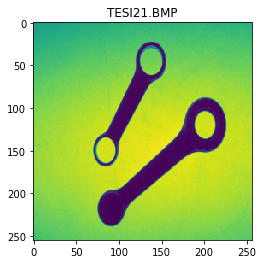

In [4]:
image = cv2.imread("../data/" + task1_image_filenames[index], cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
plt.title(task1_image_filenames[index])
plt.show()

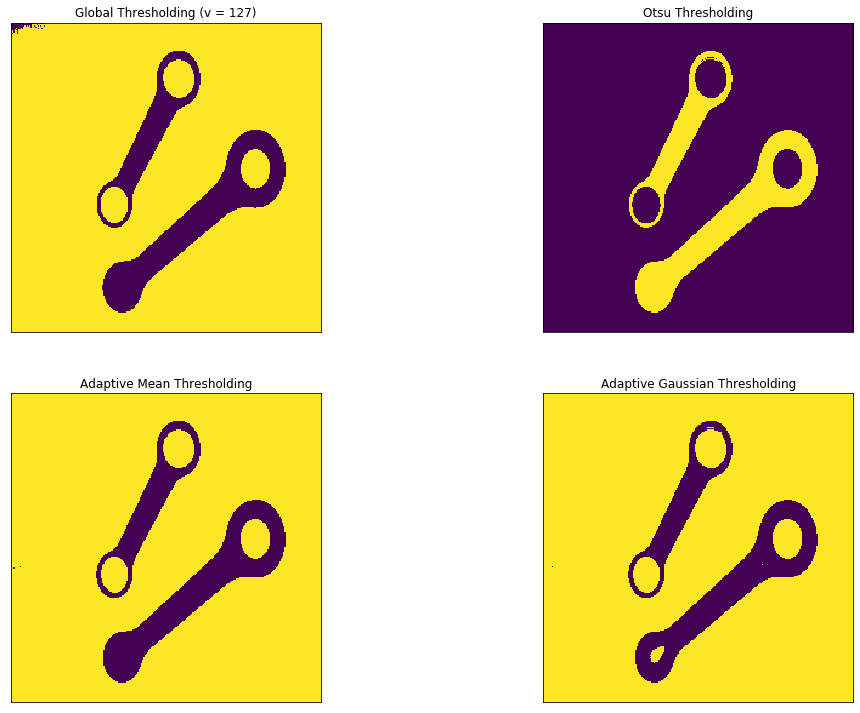

In [5]:
binay_threshold = 127
ret_binary, th_binary = cv2.threshold(image, binay_threshold, 255, cv2.THRESH_BINARY)
ret_otsu, th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
th_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 47, 14)
th_gaussian = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 47, 14)

titles = ['Global Thresholding (v = ' + str (binay_threshold) + ')', 'Otsu Thresholding', 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [th_binary, th_otsu, th_mean, th_gaussian]

plt.figure(figsize=(17.5, 12.5))

for i, img in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [6]:
rod_connectivity = 4
rod_num, rod_labelled_image, rod_info, rod_centroids = cv2.connectedComponentsWithStats(th_otsu, rod_connectivity, cv2.CV_32S)
labels = np.unique(rod_labelled_image)

In [7]:
background_label = np.argmax(rod_info[:,4])

In [8]:
def mn_moment(data, m, n):
    ''' Measure the moments of the image given the order m and n
    Inputs:
        data - the binary image
        m - order of the vertical axis
        n - order of the horizontal axis
    Output:
        the moment
    '''
    nrows, ncols = data.shape
    y_indices, x_indices = np.mgrid[:nrows, :ncols]
    return (data * x_indices ** m * y_indices ** n).sum()


In [9]:
def moments_cov(data, centroid):
    ''' Create the covariance matrix containing the moments up to second order
    Inputs:
        data - the binary image
        centroid - the centroid coordinate
    Output:
        cov - the covariance matrix containing the moments
    '''
    m10 = mn_moment(data, 1, 0)
    m01 = mn_moment(data, 0, 1)
    m00 = mn_moment(data, 0, 0)
    u11 = (mn_moment(data, 1, 1) - centroid[0] * m01) / m00
    u20 = (mn_moment(data, 2, 0) - centroid[0] * m10) / m00
    u02 = (mn_moment(data, 0, 2) - centroid[1] * m01) / m00
    cov = np.array([[u20, u11], [u11, u02]])
    return cov

In [10]:
def contact_points(data, major_equation, minor_equation):
    ''' Find the contact points between major and minor axes parallel lines and the contour of the object
    Inputs:
        data - the binary image
        major_equation - list of type [a, b, c] representing the equation of the major axis
        major_equation - list of type [a, b, c] representing the equation of the minor axis
    Outputs:
        c1 - on major axis, negative
        c2 - on major axis, positive
        c3 - on minor axis, negative
        c4 - on minor axis, positive
    '''
    min_major_distance = math.inf
    max_major_distance = -math.inf
    min_minor_distance = math.inf
    max_minor_distance = -math.inf
    c1 = [0,0]
    c2 = [0,0]
    c3 = [0,0]
    c4 = [0,0]
    
    min_barycentre_distance = math.inf
    max_barycentre_distance = -math.inf
        
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data[y,x] == 255:
                # distance from the major axis
                major_distance = (major_equation[1] * y + major_equation[0] * x + major_equation[2]) / math.sqrt((major_equation[0] ** 2) + (major_equation[1] ** 2))
                # distance from the minor axis
                minor_distance = (minor_equation[1] * y + minor_equation[0] * x + minor_equation[2]) / math.sqrt((minor_equation[0] ** 2) + (minor_equation[1] ** 2))
                
                if major_distance < min_major_distance:
                    min_major_distance = major_distance
                    c1 = [x, y]
                if major_distance > max_major_distance:
                    max_major_distance = major_distance 
                    c2 = [x, y]
                if minor_distance < min_minor_distance:
                    min_minor_distance = minor_distance
                    c3 = [x, y]
                if minor_distance > max_minor_distance:
                    max_minor_distance = minor_distance
                    c4 = [x, y]
                    
                if abs(minor_distance) < 0.75:
                    if major_distance < min_barycentre_distance:
                        min_barycentre_distance = major_distance
                    if major_distance > max_barycentre_distance:
                        max_barycentre_distance = major_distance
    
    return c1, c2, c3, c4, abs(min_barycentre_distance) + abs(max_barycentre_distance)

In [11]:
def line_intersection(p1, p2, m1, m2):
    ''' Intersect 2 lines given 2 points and the associated slopes 
    Inputs:
        p1 - first point of first line [x,y]
        p2 - fist point of second line [x,y]
        m1 - slope of first line
        m2 - slope of second line
    Outputs:
        res - the intersection of the two lines if possible, array on np.nan otherwise
        
    '''
    if p1 is None or p2 is None or m1 is None or m2 is None:
        raise ValueError("Missing some required arguments")

    a = np.array([[-m1, 1],
                  [-m2, 1]])
    b = np.array([p1[1] - m1 * p1[0], p2[1] - m2 * p2[0]])
    try:
        res = np.linalg.solve(a, b)
    except:
        res = np.array([np.nan, np.nan])

    return res

Error
63.76405280880342
-0.8969811937217301 -0.8969811937217301 0.44206870292923933 0.4420687029292392


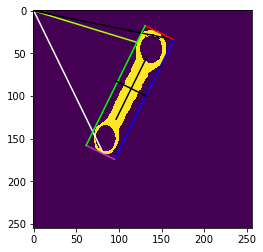

42.20820105456108
-0.6718266178069507 -0.6718266178069509 0.7407084417002909 0.7407084417002909


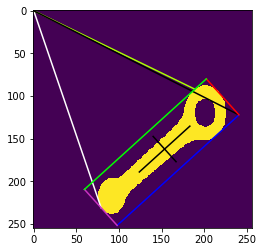

[{'index': 1,
  'area': 2473,
  'centroid': array([114.29720987,  91.23736353]),
  'type': 'B',
  'hole': [{'diameter': 29.20737055903114,
    'centre': array([137.66268657,  45.25074627])},
   {'diameter': 2.763953195770684, 'centre': array([137.5,  28. ])},
   {'diameter': 1.1283791670955126, 'centre': array([142.,  29.])}],
  'angle': 63.76405280880342,
  'bw': 18.78522991670332,
  'length': 156.573551477542,
  'width': 37.11554734261418},
 {'index': 2,
  'area': 5271,
  'centroid': array([153.43881616, 162.16467463]),
  'type': 'A',
  'hole': [{'diameter': 28.2320377409108,
    'centre': array([200.57348243, 119.7571885 ])}],
  'angle': 42.20820105456108,
  'bw': 21.9287343343089,
  'length': 192.91435835857854,
  'width': 57.00056676866949}]

In [12]:
rods = []

for label in labels:
    if label != background_label:
        rod = {"index":label}
        rods.append(rod)
        
        rods[-1]["area"] = rod_info[label][4]
        rods[-1]["centroid"] = rod_centroids[label]
        
        rod_image = th_otsu.copy()
        rod_image[rod_labelled_image == label] = 255
        rod_image[rod_labelled_image != label] = 0
        
        hole_image = rod_image + 255
        hole_image[hole_image != 255] = 0

        hole_connectivity = 4
        hole_num, hole_labelled_image, hole_info, hole_centroids = cv2.connectedComponentsWithStats(hole_image, hole_connectivity, cv2.CV_32S)
        
        # Possible use of
        # circularity = (Perimeter .^ 2) ./ (4 * pi * area);
        
        rods[-1]["type"] = "A"
        rods[-1]["hole"] = []
        
        for index, area in enumerate(np.sort(hole_info[:,4])):
            if index > 1:
                rods[-1]["hole"].append({"diameter":math.sqrt((hole_info[index,4] / math.pi)) * 2, "centre":hole_centroids[index]})
                if index - 2 == 1:
                    rods[-1]["type"] = "B"
                elif index - 2 > 1:
                    print("Error")
                    break
                
        if rods[-1]["hole"] == []:
            print("Error")
            
        cov = moments_cov(rod_image, rods[-1]["centroid"])
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        sort_indices = np.argsort(eigenvalues)[::-1]
        major_axes = eigenvectors[:, sort_indices[0]]
        minor_axes = eigenvectors[:, sort_indices[1]]

        #alpha = -math.sin(theta)
        #beta  =  math.cos(theta) 
        alpha = major_axes[1]
        beta = major_axes[0]

        theta = abs(-0.5 * math.atan2((2 * cov[0,1]), (cov[0,0] - cov[1,1])))
        
        #theta = math.atan2(alpha, beta)
        rods[-1]["angle"] = math.degrees(theta)
        print(math.degrees(theta))
        
        print(-math.sin(theta), alpha, math.cos(theta), beta)
        major_equation = [alpha, -beta, beta * rods[-1]["centroid"][1] - alpha * rods[-1]["centroid"][0]]
        minor_equation = [beta, alpha, -beta * rods[-1]["centroid"][0] - alpha * rods[-1]["centroid"][1]]
        
        c1, c2, c3, c4, rods[-1]["bw"] = contact_points(rod_image, major_equation, minor_equation)
               
        v1 = line_intersection(c1, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
        v2 = line_intersection(c1, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
        v3 = line_intersection(c2, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
        v4 = line_intersection(c2, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
        
        rods[-1]["length"] = math.sqrt(((v1[0] - v2[0])**2) + ((v1[1] - v2[1])**2))
        rods[-1]["width"] = math.sqrt(((v1[0] - v3[0])**2) + ((v1[1] - v3[1])**2))
        
        # Draw        
        # MER
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color="#0000ff") #blue
        plt.plot([v2[0], v4[0]], [v2[1], v4[1]], color="#ff0000") #red
        plt.plot([v3[0], v1[0]], [v3[1], v1[1]], color="#c932c1") #purple
        plt.plot([v4[0], v3[0]], [v4[1], v3[1]], color="#00ff00") #green
        
        # Major and minor axes
        scale = 20
        plt.plot([major_axes[0] * -scale * 2 + rods[-1]["centroid"][0], major_axes[0] * scale * 2 + rods[-1]["centroid"][0]],
                 [major_axes[1] * -scale * 2 + rods[-1]["centroid"][1], major_axes[1] * scale * 2 + rods[-1]["centroid"][1]], color='black')
        plt.plot([minor_axes[0] * -scale + rods[-1]["centroid"][0], minor_axes[0] * scale + rods[-1]["centroid"][0]],
                 [minor_axes[1] * -scale + rods[-1]["centroid"][1], minor_axes[1] * scale + rods[-1]["centroid"][1]], color='black')
        plt.imshow(rod_image)
        plt.show()


plt.show()
rods